# <font style="color:#008fff;">Machine Learning Modeling</font>
<hr>

In [63]:
import pandas as pd
import numpy as np
import time
import os
import sklearn
import warnings
import sys
import random
import pickle

import graphviz

# Importing feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

# ML Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics/Visualizations
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

#Disabling Warnings
warnings.filterwarnings('ignore')

# to make this notebook's output stable across runs
random.seed(42)

## <font style="color:#008fff;">Reading in preprocessed training dataset</font>

In [2]:
def loadDataset(file_name, idx_col=False):
    start_time= time.time()
    if idx_col:
        df = pd.read_csv(file_name, index_col=[0])
    else:
        df = pd.read_csv(file_name)
    print("***Elapsed time to read csv files --- %s seconds ---***" % (time.time() - start_time))
    return df


df_train_preprocessed = loadDataset("Dataset/preprocessed_training_data.csv")

***Elapsed time to read csv files --- 0.06974983215332031 seconds ---***


In [3]:
df_train_preprocessed.head(5)

,url_vect,is_gov_tld,who_is,https,profanity_score_prob,url_len_scaled,js_len_scaled,js_obf_len_scaled,label
0,0.044,0,0,0,0.901780,0.152542,0.842993,0.663632,1
1,0.005,0,1,1,0.001813,0.593220,0.097764,0.000000,0
2,0.033,0,0,0,0.965517,0.864407,0.727081,0.471829,1
3,0.046,0,1,1,0.049674,0.271186,0.038052,0.000000,0
4,0.046,0,0,0,0.955261,0.525424,0.600632,0.421721,1


### Split our dataset into X_train and y_train

In [4]:
X_train = df_train_preprocessed.drop('label', axis=1)
y_train = df_train_preprocessed['label']

In [5]:
X_train.shape, y_train.shape

((54506, 8), (54506,))

## <font style="color:#008fff;">Feature Selection</font>

There are a handful of feature selection methods in Scikit-Learn with classification. According to Sklearn's documentation, common feature selection algorithms include `chi2`, `f_classif`, and `mutual_info_classif` (https://scikit-learn.org/stable/modules/feature_selection.html)
 - We will try out the 3 we see in this documentation to see which features are most commonly chosen

**Other Potential Feature Selection methods to experiment in the future: Mean Absolute Difference, Fisher Score, different method from scratch**

### Feature selection using Sklearn's chi-squared:

In [6]:
# Taking the top 5 most best descriptive features using chi-squared testing
chi2_selector = SelectKBest(chi2, k=5)
X_kbest_chi2 = chi2_selector.fit_transform(X_train, y_train)

print(f'Out of {X_train.shape[1]} features in our original dataset, we get the top {X_kbest_chi2.shape[1]} chosen by chi2')

# Showing which columns chi2 has chosen
selected_features_chi2 = chi2_selector.get_support(indices=True)
print(f'Top 5 features selected using chi-squared: {list(X_train.iloc[:, selected_features_chi2].columns)}')

Out of 8 features in our original dataset, we get the top 5 chosen by chi2
Top 5 features selected using chi-squared: ['who_is', 'https', 'profanity_score_prob', 'js_len_scaled', 'js_obf_len_scaled']


### Feature selection using Sklearn's f_classif

In [7]:
# Taking the top 5 best descriptive feature using f classification
f_classif_selector = SelectKBest(f_classif, k=5)
X_kbest_f_classif = f_classif_selector.fit_transform(X_train, y_train)

print(f'Out of {X_train.shape[1]} features in our original dataset, we get the top {X_kbest_f_classif.shape[1]} chosen by f_classif')

# Showing which columns f_classif has chosen
selected_features_f_classif = f_classif_selector.get_support(indices=True)
print(f'Top 5 features selected using f_classif: {list(X_train.iloc[:, selected_features_f_classif].columns)}')

Out of 8 features in our original dataset, we get the top 5 chosen by f_classif
Top 5 features selected using f_classif: ['who_is', 'https', 'profanity_score_prob', 'js_len_scaled', 'js_obf_len_scaled']


### Feature selection using Sklearn's mutual_info_classif

In [8]:
# Taking the top 5 best descriptive feature using mutual info classif
MIC_selector = SelectKBest(mutual_info_classif, k=5)
X_kbest_MIC = MIC_selector.fit_transform(X_train, y_train)

print(f'Out of {X_train.shape[1]} features in our original dataset, we get the top {X_kbest_MIC.shape[1]} chosen by mutual_info_classif')

# Showing which columns f_classif has chosen
selected_features_MIC = MIC_selector.get_support(indices=True)
print(f'Top 5 features selected using f_classif: {list(X_train.iloc[:, selected_features_MIC].columns)}')

Out of 8 features in our original dataset, we get the top 5 chosen by mutual_info_classif
Top 5 features selected using f_classif: ['who_is', 'https', 'profanity_score_prob', 'js_len_scaled', 'js_obf_len_scaled']


### It seems that all 3 methods from scikit-learn all chose 'who_is', 'https', 'profanity_score_prob', 'js_len_scaled',  and 'js_obf_len_scaled' as their top 5 features. We will be using this for now.

In [9]:
X_kbest_features_train = X_kbest_chi2
X_kbest_features_train

array([[0.00000000e+00, 0.00000000e+00, 9.01780298e-01, 8.42992624e-01,
        6.63632491e-01],
       [1.00000000e+00, 1.00000000e+00, 1.81264953e-03, 9.77637279e-02,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.65517263e-01, 7.27081138e-01,
        4.71829249e-01],
       ...,
       [1.00000000e+00, 1.00000000e+00, 7.20261896e-04, 4.27350427e-02,
        0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 9.36110254e-03, 2.19529329e-01,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.72637009e-01, 4.19388830e-01,
        1.96309665e-01]])

## <font style="color:#008fff;">Preprocess Testing Data to Make Compatible With ML Models During Testing</font>

In [10]:
from profanity_check import predict_prob, predict
from urllib.parse import urlparse
from tld import get_tld

# Getting rid of outliers using clamp transformation
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    
    for index, val in df.iteritems():
        if val < (q1 - 1.5 * IQR): # Small outliers below lower quartile
            df[index] = (q1 - 1.5 * IQR)
        elif val > (q3 + 1.5 * IQR): # Large outliers above upper quartile
            df[index] = (q3 + 1.5 * IQR)

    return df

# If tld == gov, then is_gov_tld = 1, else gov_tld = 0
def make_gov_column(df):
    gov_col = []
    for index, val in df.iteritems():
        if val == 'gov':
            gov_col.append(1)
        else:
            gov_col.append(0)
    return np.array(gov_col)


def clean_url(url):
    url_text=""
    try:
        domain = get_tld(url, as_object=True)
        domain = get_tld(url, as_object=True)
        url_parsed = urlparse(url)
        url_text= url_parsed.netloc.replace(domain.tld," ").replace('www',' ') +" "+ url_parsed.path+" "+url_parsed.params+" "+url_parsed.query+" "+url_parsed.fragment
        url_text = url_text.translate(str.maketrans({'?':' ','\\':' ','.':' ',';':' ','/':' ','\'':' '}))
        url_text.strip(' ')
        url_text.lower()
    except:
        url_text = url_text.translate(str.maketrans({'?':' ','\\':' ','.':' ',';':' ','/':' ','\'':' '}))
        url_text.strip(' ')
    return url_text

def predict_profanity(url_cleaned):
    arr=predict_prob(url_cleaned.astype(str).to_numpy())
    arr= arr.round(decimals=3)
    #df['url_vect'] = pd.DataFrame(data=arr,columns=['url_vect'])
    return arr

In [11]:
def preprocess(df):
    start_time= time.time()

    # ------------ Address outliers via clamp transformation --------------
    url_len_clamped = df['url_len'].copy()
    url_len_clamped = find_outliers_IQR(url_len_clamped)
    js_len_clamped = df['js_len'].copy()
    js_len_clamped = find_outliers_IQR(js_len_clamped)
    js_obf_len_clamped = df['js_obf_len'].copy()
    js_obf_len_clamped = find_outliers_IQR(js_obf_len_clamped)
    
    df['url_len'] = url_len_clamped
    df['js_len'] = js_len_clamped
    df['js_obf_len'] = js_obf_len_clamped
    
    # --------------- Scaling numerical features ---------------
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    
    url_len_scaled = scaler.fit_transform(df[['url_len']])
    df['url_len_scaled'] = url_len_scaled

    js_len_scaled = scaler.fit_transform(df[['js_len']])
    df['js_len_scaled'] = js_len_scaled

    js_obf_len_scaled = scaler.fit_transform(df[['js_obf_len']])
    df['js_obf_len_scaled'] = js_obf_len_scaled
    
    
    # ---------------- Binary Encoding for Categorical Attributes ------------------
    identifyWho_Is = {'incomplete': 0, 'complete': 1}
    df['who_is'] = [identifyWho_Is[item] for item in df.who_is]
    
    identifyHTTPS = {'no': 0, 'yes': 1}
    df.https = [identifyHTTPS[item] for item in df.https]
    
    # --------------- Handling TLD Column -------------------------
    gov_binary_val = make_gov_column(df['tld'])
    df.insert(2, column = "is_gov_tld", value=gov_binary_val)
    
    
    # ---------------- Probabilty based profanity score on text columnsk ------------------
    from profanity_check import predict_prob, predict
    profanity_score_prob = predict_prob(np.array(df['content']))
    df.insert(5, column='profanity_score_prob', value=profanity_score_prob)
    
    
    # ------------------ Cleaning URL's --------------------
    url_cleaned = df['url'].map(clean_url)
    df.insert(1, column='url_cleaned', value=url_cleaned)
    url_vect = predict_profanity(df['url_cleaned'])
    df.insert(2, column='url_vect', value=url_vect)
    
    # ---------------------- Preprocess labels into binary values ----------------------
    identifyLabels = {'bad': 1, 'good': 0}
    df['label'] = [identifyLabels[item] for item  in df.label]
    
    # ------------ Drop Unecessary Columns, or Original Columns after preprocessing that still remain -------------
    df.drop(['geo_loc', 'ip_add', 'url_len', 'js_len', 'js_obf_len', 'tld', 'content', 'url', 'url_cleaned'], axis=1, inplace=True)
    
    # ---------------------- Rearrange Columns ----------------------
    titles = ['url_vect', 'is_gov_tld', 'who_is', 'https', 'profanity_score_prob', 
              'url_len_scaled', 'js_len_scaled','js_obf_len_scaled',
              'label'] # Same order as our training data

    df = df[titles] 
    
    print("***Elapsed time preprocess --- %s seconds ---***" % (time.time() - start_time))
    return df

In [12]:
df_test = loadDataset("Dataset/Webpages_Classification_test_data.csv", idx_col=True)

***Elapsed time to read csv files --- 7.859706401824951 seconds ---***


In [13]:
df_test.shape

(361934, 11)

### NOTE: Our current training dataset has 54,506 rows when running df_train_preprocessed.shape. But, our test dataset has 361,934 when running df_test.shape. We want to make our training split be 80% and testing split be 20%. Therefore, we can reduce our test split by sampling ~13,627 rows to make the size of our testing data proportional to test data, such that there is a 50/50 split between good and bad labels to see how well our ML algorithms perform for each label

In [23]:
# NOTE: No longer need to run this cell anymore
df_test = df_test.sample(13627)
df_test_preprocessed = preprocess(df_test)

***Elapsed time preprocess --- 2.7170865535736084 seconds ---***


In [24]:
# Saving preprocessed testing dataset into disk
#df_test_preprocessed.to_csv('Dataset/preprocessed_testing_data.csv', index=False)

### Reading finalized preprocessed files

In [12]:
# Splitting our test dataset into X and y
X_train = pd.read_csv('Dataset/preprocessed_training_data.csv').drop('label', axis=1)
y_train = pd.read_csv('Dataset/preprocessed_training_data.csv')['label']

X_test = pd.read_csv('Dataset/preprocessed_testing_data.csv').drop('label', axis=1)
y_test = pd.read_csv('Dataset/preprocessed_testing_data.csv')['label']

# X_test, but only with columns we've chosen during feature selection
chosen_features = ['who_is', 'https', 'profanity_score_prob', 'js_len_scaled', 'js_obf_len_scaled']
X_kbest_features_train = X_train[chosen_features].values
X_kbest_features_test = X_test[chosen_features].values

## <font style="color:#008fff;">ML Modeling: K-Nearest Neighbors</font>

### Building KNN Model for the FULL feature set (X_train):

In [13]:
knn_full = KNeighborsClassifier(n_neighbors=3)
knn_full.fit(X_train.values, y_train.values)

KNeighborsClassifier(n_neighbors=3)

In [27]:
# Save the model to disk
#knn_full_filename = 'Models/knn_full_features.sav'
#pickle.dump(knn_full, open(knn_full_filename, 'wb'))

In [14]:
kf_initial_predictions = knn_full.predict(X_test.values)
print('------------------------------Initial results------------------------------')
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=kf_initial_predictions))
print(f'Area Under the Curve: {roc_auc_score(y_true=y_test, y_score=kf_initial_predictions)}')

------------------------------Initial results------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     13330
           1       0.07      1.00      0.14       297

    accuracy                           0.73     13627
   macro avg       0.54      0.86      0.49     13627
weighted avg       0.98      0.73      0.82     13627

Area Under the Curve: 0.8620030007501875


### Building KNN Model for the feature set after FEATURE SELECTION (X_kbest_features_train):

In [15]:
# KNN with reduced features
knn_reduced = KNeighborsClassifier(n_neighbors=3)
knn_reduced.fit(X_kbest_features_train, y_train.values)

KNeighborsClassifier(n_neighbors=3)

In [30]:
# Save the model to disk
# knn_reduced_filename = 'Models/knn_reduced_features.sav'
# pickle.dump(knn_reduced, open(knn_reduced_filename, 'wb'))

In [16]:
kr_initial_predictions = knn_reduced.predict(X_kbest_features_test)
print('------------------------------Initial results------------------------------')
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=kr_initial_predictions))
print(f'Area Under the Curve: {roc_auc_score(y_true=y_test, y_score=kr_initial_predictions)}')

------------------------------Initial results------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73     13330
           1       0.05      1.00      0.09       297

    accuracy                           0.58     13627
   macro avg       0.52      0.79      0.41     13627
weighted avg       0.98      0.58      0.71     13627

Area Under the Curve: 0.7862340585146287


## <font style="color:#008fff;">ML Modeling: (Gaussian) Naive Bayes</font>

### Building Naive Bayes Model for the FULL feature set:

In [17]:
gnb_full = GaussianNB()
gnb_full.fit(X_train.values, y_train.values)

GaussianNB()

In [33]:
# Save the model to disk
# gnb_full_filename = 'Models/gnb_full_features.sav'
# pickle.dump(gnb_full, open(gnb_full_filename, 'wb'))

In [18]:
gf_initial_predictions = gnb_full.predict(X_test.values)
print('------------------------------Initial results------------------------------')
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=gf_initial_predictions))
print(f'Area Under the Curve: {roc_auc_score(y_true=y_test, y_score=gf_initial_predictions)}')

------------------------------Initial results------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78     13330
           1       0.06      1.00      0.11       297

    accuracy                           0.65     13627
   macro avg       0.53      0.82      0.45     13627
weighted avg       0.98      0.65      0.77     13627

Area Under the Curve: 0.818496543327751


### Building Naive Bayes Model for the feature set after FEATURE SELECTION:

In [22]:
gnb_reduced = GaussianNB()
gnb_reduced.fit(X_kbest_features_train, y_train.values)

GaussianNB()

In [36]:
# Save the model to disk
# gnb_reduced_filename = 'Models/gnb_reduced_features.sav'
# pickle.dump(gnb_reduced, open(gnb_reduced_filename, 'wb'))

In [23]:
gr_initial_predictions = gnb_reduced.predict(X_kbest_features_test)
print('------------------------------Initial results------------------------------')
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=gr_initial_predictions))
print(f'Area Under the Curve: {roc_auc_score(y_true=y_test, y_score=gr_initial_predictions)}')

------------------------------Initial results------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     13330
           1       0.08      0.95      0.15       297

    accuracy                           0.77     13627
   macro avg       0.54      0.86      0.51     13627
weighted avg       0.98      0.77      0.85     13627

Area Under the Curve: 0.8579432736972121


## <font style="color:#008fff;">ML Modeling: Decision Tree</font> 

### Building Decision Tree Model for the FULL feature set:

In [24]:
dc_full = DecisionTreeClassifier(max_depth=3)
dc_full.fit(X_train.values, y_train.values)

DecisionTreeClassifier(max_depth=3)

In [39]:
#Save the model to disk
# dc_full_filename = 'Models/dc_full_features.sav'
# pickle.dump(dc_full, open(dc_full_filename, 'wb'))

In [25]:
df_initial_predictions = dc_full.predict(X_test.values)
print('------------------------------Initial results------------------------------')
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=df_initial_predictions))
print(f'Area Under the Curve: {roc_auc_score(y_true=y_test, y_score=df_initial_predictions)}')

------------------------------Initial results------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.38      0.55     13330
           1       0.03      1.00      0.07       297

    accuracy                           0.39     13627
   macro avg       0.52      0.69      0.31     13627
weighted avg       0.98      0.39      0.54     13627

Area Under the Curve: 0.6893848462115528


### Building Random Forest Model for feature set after FEATURE SELECTION

In [26]:
dc_reduced = DecisionTreeClassifier(max_depth=3)
dc_reduced.fit(X_kbest_features_train, y_train.values)

DecisionTreeClassifier(max_depth=3)

In [48]:
#Save the model to disk
# dc_reduced_filename = 'Models/dc_reduced_features.sav'
# pickle.dump(dc_reduced, open(dc_reduced_filename, 'wb'))

In [27]:
dr_initial_predictions = dc_reduced.predict(X_kbest_features_test)
print('------------------------------Initial results------------------------------')
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=dr_initial_predictions))
print(f'Area Under the Curve: {roc_auc_score(y_true=y_test, y_score=dr_initial_predictions)}')

------------------------------Initial results------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.38      0.55     13330
           1       0.03      1.00      0.07       297

    accuracy                           0.39     13627
   macro avg       0.52      0.69      0.31     13627
weighted avg       0.98      0.39      0.54     13627

Area Under the Curve: 0.6893848462115528


## <font style="color:#008fff;">ML Modeling: Random Forest</font> 

### Building Random Forest Model for the FULL feature set:

In [28]:
rfc_full = RandomForestClassifier(n_estimators=100, random_state=100) # Random_state is a seeded value and n_estimators are the n amount of trees
rfc_full.fit(X_train.values, y_train.values)

RandomForestClassifier(random_state=100)

In [52]:
#Save the model to disk
#rfc_full_filename = 'Models/rfc_full_features.sav'
#pickle.dump(rfc_full, open(rfc_full_filename, 'wb'))

In [29]:
rf_initial_predictions = rfc_full.predict(X_test.values)
print('------------------------------Initial results------------------------------')
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=rf_initial_predictions))
print(f'Area Under the Curve: {roc_auc_score(y_true=y_test, y_score=rf_initial_predictions)}')

------------------------------Initial results------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.38      0.55     13330
           1       0.03      1.00      0.07       297

    accuracy                           0.39     13627
   macro avg       0.52      0.69      0.31     13627
weighted avg       0.98      0.39      0.54     13627

Area Under the Curve: 0.6897599399849963


### Building Random Forest Model for feature set after FEATURE SELECTION

In [30]:
rfc_reduced = RandomForestClassifier(n_estimators=100, random_state=100) #Random_state is a seeded value and n_estimators are the n amount of trees
rfc_reduced.fit(X_kbest_features_train, y_train.values)

RandomForestClassifier(random_state=100)

In [54]:
#Save the model to disk
rfc_reduced_filename = 'Models/rfc_reduced_features.sav'
pickle.dump(rfc_reduced, open(rfc_reduced_filename, 'wb'))

In [31]:
rr_initial_predictions = rfc_reduced.predict(X_kbest_features_test)
print('------------------------------Initial results------------------------------')
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=rr_initial_predictions))
print(f'Area Under the Curve: {roc_auc_score(y_true=y_test, y_score=rr_initial_predictions)}')

------------------------------Initial results------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.38      0.55     13330
           1       0.03      1.00      0.07       297

    accuracy                           0.39     13627
   macro avg       0.52      0.69      0.31     13627
weighted avg       0.98      0.39      0.54     13627

Area Under the Curve: 0.6892723180795199


### We also experiment with different combinations of features after using Scikit-Learn's feature selection methods. We've noticed that Naive Bayes, Decision Trees, and Random Forests worked best for smaller feature sets. Specifically, 'url_vect', 'is_gov_tld', 'js_obf_len_scaled'. This will be the new reduced feature sets for NB, DT, and RF models

In [32]:
chosen_cols = ['url_vect', 'is_gov_tld', 'js_obf_len_scaled']
experiment_X_train = X_train[chosen_cols]
experiment_X_test = X_test[chosen_cols]

## <font style="color:#008fff;">Performance Evaluation and Tuning of Each ML Model</font>
 - Apply 4 or more performance metrics to analyze the results
 - Include 3 or more visualization techniques for presenting the results
 - Compare and analyze all the ML models that you have built for the project and present the performance analysis

### Loading all of our currently saved machine learning models from disk

In [33]:
# ---------------------- KNN ----------------------
knn_full_filename = 'Models/knn_full_features.sav' # Full feature set
knn_full = pickle.load(open(knn_full_filename, 'rb'))

knn_reduced_filename = 'Models/knn_reduced_features.sav' # Reduced feature set
knn_reduced = pickle.load(open(knn_reduced_filename, 'rb'))


# ---------------------- Naive Bayes ----------------------
gnb_full_filename = 'Models/gnb_full_features.sav'
gnb_full = pickle.load(open(gnb_full_filename, 'rb'))

gnb_reduced_filename = 'Models/gnb_reduced_features.sav'
gnb_reduced = pickle.load(open(gnb_reduced_filename, 'rb'))


# ---------------------- Decision Trees ----------------------
dc_full_filename = 'Models/dc_full_features.sav'
dc_full = pickle.load(open(dc_full_filename, 'rb'))

dc_reduced_filename = 'Models/dc_reduced_features.sav'
dc_reduced = pickle.load(open(dc_reduced_filename, 'rb'))


# ---------------------- Random Forest ----------------------
rfc_full_filename = 'Models/rfc_full_features.sav'
rfc_full = pickle.load(open(rfc_full_filename, 'rb'))

rfc_reduced_filename = 'Models/rfc_reduced_features.sav'
rfc_reduced = pickle.load(open(rfc_reduced_filename, 'rb'))

### Useful functions for evaluation/visualization:
 - Evaluation Scores we will be using: **Accuracy, Precision, Recall, F1-Score, AUC**
 - Visualization techniques for evaluation: **Confusion matrix, ROC, Classification Report**

In [34]:
def draw_conf_matrix(actual, predicted, title):
    plt.figure(figsize = (7,5))
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    cf_matrix = confusion_matrix(actual, predicted)
    ht_mp = sns.heatmap(cf_matrix, annot=True, fmt='g')
    
    # **NOTE: In this case: Legitimate (NOT Malicious) is our NEGATIVE class, while Malicious is our POSITIVE class**
    ht_mp.set(xlabel='Predicted', ylabel='Actual', 
              xticklabels=['Not Malicious (Negative)', 'Malicious (Positive)'], 
              yticklabels=['Not Malicious (Negative)', 'Malicious (Positive)'])
        
def plot_show_auc(full_feat_pred, reduced_feat_pred, y_test, title):
    # calculate FPR and TPR for each model
    fpr_full_features, tpr_full_features, _ = roc_curve(y_test, full_feat_pred)
    fpr_reduced_features, tpr_reduced_features, _ = roc_curve(y_test, reduced_feat_pred)

    # create an empty figure
    fig, ax = plt.subplots()

    # create RocCurveDisplay object for each model
    roc_display_full_features = RocCurveDisplay(fpr=fpr_full_features, tpr=tpr_full_features, roc_auc=roc_auc_score(y_test, full_feat_pred), estimator_name='Full Features')
    roc_display_reduced_features = RocCurveDisplay(fpr=fpr_reduced_features, tpr=tpr_reduced_features, roc_auc=roc_auc_score(y_test, reduced_feat_pred), estimator_name='Reduced Features')

    # plot each RocCurveDisplay object on the same graph
    roc_display_full_features.plot(ax=ax)
    roc_display_reduced_features.plot(ax=ax)

    # add dashed red line representing random guessing
    ax.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')

    # re-add legend with new line
    ax.legend()

    # add axis labels and title
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)

## <font style="color:#008fff;">Evaluation and Tuning: K-Nearest Neighbors</font>

## Elbow Method: Note that our error rate keeps doing down. Although we can experiment for larger K values to find the most optimal value, computation takes too long (Going beyond 7 minutes), so we will limit oursevles between 10-200 for the scope of this project

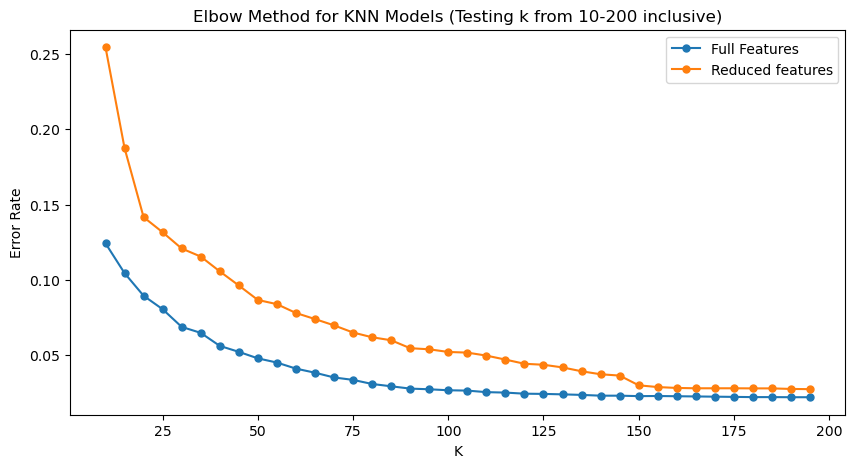

In [60]:
MIN = 10
MAX = 200
INCREMENT = 5

# ----------------------------- Full Feature Sets ------------------------------
error_rate = []
neighbor_error_coordinate = dict()
for i in range(MIN,MAX,INCREMENT):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(X_train.values, y_train.values)
    preds = knn_model.predict(X_test.values)
    err = 1 - accuracy_score(y_test, preds)
    error_rate.append(err) # Storing error rate into array used for plotting later
    neighbor_error_coordinate[i] = err # Storing key-value pair of (k, error rate), which will be passed into findBestK()

# ----------------------------- Reduced Feature Sets ----------------------------
error_rate2 = []
neighbor_error_coordinate2 = dict()
for i in range(MIN,MAX,INCREMENT):
    knn_model2 = KNeighborsClassifier(n_neighbors=i)
    knn_model2.fit(X_kbest_features_train, y_train.values)
    preds = knn_model2.predict(X_kbest_features_test)
    err2 = 1 - accuracy_score(y_test, preds)
    error_rate2.append(err2)
    neighbor_error_coordinate2[i] = err2
    
# Generate some data for our curves
x1, x2 = np.arange(MIN,MAX,INCREMENT), np.arange(MIN,MAX,INCREMENT)
y1, y2 = np.array(error_rate), np.array(error_rate2)

fig, ax = plt.subplots(figsize=(10, 5)) # Create a figure and axis object
ax.plot(x1, y1, label='Full Features', marker='o', markersize=5) # Plot the first curve
ax.plot(x2, y2, label='Reduced features', marker='o', markersize=5) # Plot the second curve
ax.legend() # Add a legend
ax.set_xlabel('K')
ax.set_ylabel('Error Rate')
ax.set_title(f'Elbow Method for KNN Models (Testing k from {MIN}-{MAX} inclusive)')
plt.show()

In [61]:
# Defining function to find optimal K value
def findBestK(neighbor_err_coord):
    return min(neighbor_err_coord, key=neighbor_err_coord.get)


best_k_1 = findBestK(neighbor_error_coordinate)
best_k_2 = findBestK(neighbor_error_coordinate2)
print(f'Best K value for our model on full features: {best_k_1} with error rate {neighbor_error_coordinate[best_k_1]}')
print(f'Best K value for our model on reduced features: {best_k_2} with error rate {neighbor_error_coordinate2[best_k_2]}')

Best K value for our model on full features: 190 with error rate 0.021941733323548873
Best K value for our model on reduced features: 195 with error rate 0.027298745138328306


### Evaluating KNN using full features (With k = 190)

In [35]:
knn_full = KNeighborsClassifier(n_neighbors=190)
knn_full.fit(X_train.values, y_train.values)

KNeighborsClassifier(n_neighbors=190)

In [36]:
knn_full_predictions = knn_full.predict(X_test.values)

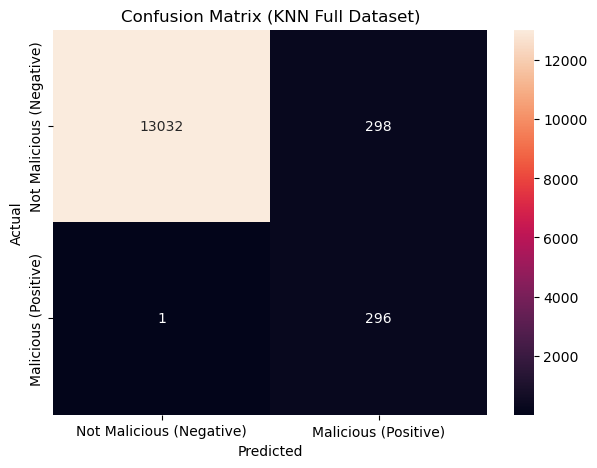

In [37]:
draw_conf_matrix(actual=y_test, predicted=knn_full_predictions, title="Confusion Matrix (KNN Full Dataset)")

In [38]:
print(classification_report(y_true=y_test, y_pred=knn_full_predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     13330
           1       0.50      1.00      0.66       297

    accuracy                           0.98     13627
   macro avg       0.75      0.99      0.83     13627
weighted avg       0.99      0.98      0.98     13627



### Evaluating KNN using feature reduction (With k = 195). Using Features 'who_is', 'https', 'profanity_score_prob', 'js_len_scaled', 'js_obf_len_scaled'

In [39]:
knn_reduced = KNeighborsClassifier(n_neighbors=195)
knn_reduced.fit(X_kbest_features_train, y_train.values)

KNeighborsClassifier(n_neighbors=195)

In [40]:
knn_reduced_predictions = knn_reduced.predict(X_kbest_features_test)

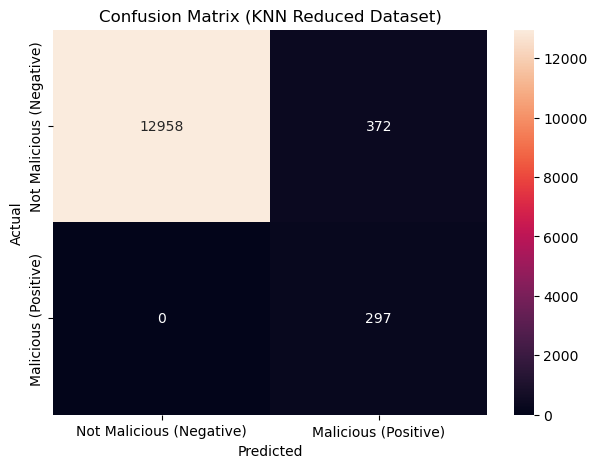

In [41]:
draw_conf_matrix(actual=y_test, predicted=knn_reduced_predictions, title="Confusion Matrix (KNN Reduced Dataset)")

In [42]:
print(classification_report(y_true=y_test, y_pred=knn_reduced_predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     13330
           1       0.44      1.00      0.61       297

    accuracy                           0.97     13627
   macro avg       0.72      0.99      0.80     13627
weighted avg       0.99      0.97      0.98     13627



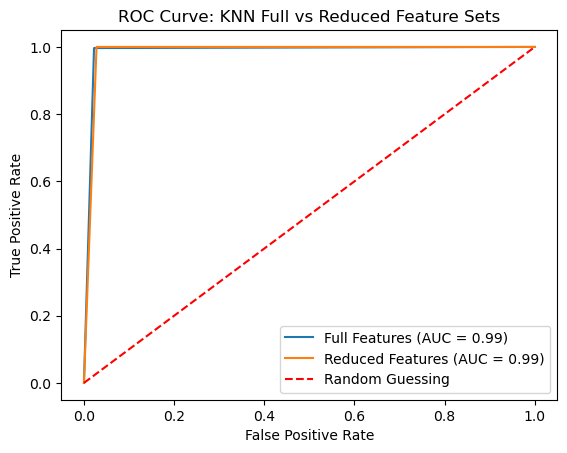

In [43]:
plot_show_auc(knn_full_predictions, knn_reduced_predictions, y_test, 'ROC Curve: KNN Full vs Reduced Feature Sets')

### Saving Our Optimized KNN Models

In [71]:
#Save the optimized model to disk
#knn_full_filename = 'Models/Optimized/knn_full_features_opt.sav'
#pickle.dump(knn_full, open(knn_full_filename, 'wb'))

#knn_reduced_filename = 'Models/Optimized/knn_reduced_features_opt.sav'
#pickle.dump(knn_reduced, open(knn_reduced_filename, 'wb'))

## <font style="color:#008fff;">Evaluation and Tuning: Naive Bayes</font>

### Tuning Naive Bayes using full features

In [44]:
# Grid Search
nb_params = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
gnb_full = GaussianNB()
grid_search = GridSearchCV(gnb_full, nb_params, cv=3)
grid_search.fit(X_train.values, y_train.values)
grid_search.best_params_

{'var_smoothing': 1e-09}

In [45]:
gnb_full = GaussianNB(var_smoothing=1e-09)
gnb_full.fit(X_train.values, y_train.values)
gnb_full_predictions = gnb_full.predict(X_test.values)

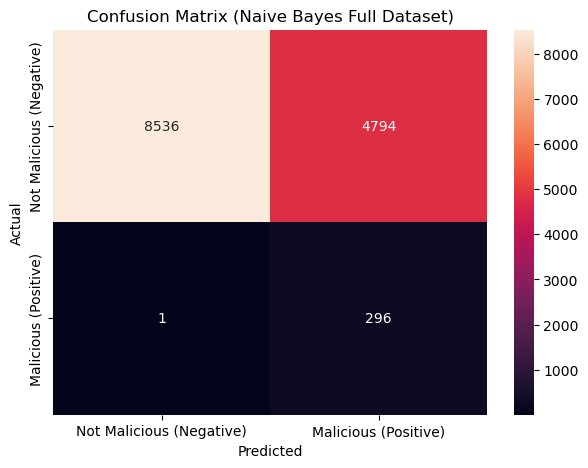

In [46]:
draw_conf_matrix(actual=y_test, predicted=gnb_full_predictions, title="Confusion Matrix (Naive Bayes Full Dataset)")

In [47]:
print(classification_report(y_true=y_test, y_pred=gnb_full_predictions))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78     13330
           1       0.06      1.00      0.11       297

    accuracy                           0.65     13627
   macro avg       0.53      0.82      0.45     13627
weighted avg       0.98      0.65      0.77     13627



In [72]:
#Save the optimized model to disk
#gnb_full_filename = 'Models/Optimized/gnb_full_features_opt.sav'
#pickle.dump(gnb_full, open(gnb_full_filename, 'wb'))

### Tuning Naive Bayes on Reduced Features: 'url_vect', 'is_gov_tld', 'js_obf_len_scaled'

In [101]:
nb_params = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
gnb_full = GaussianNB()
grid_search = GridSearchCV(gnb_full, nb_params, cv=3)
grid_search.fit(experiment_X_train.values, y_train.values)
grid_search.best_params_

{'var_smoothing': 1e-09}

In [102]:
gnb_reduced = GaussianNB(var_smoothing=1e-09)
gnb_reduced.fit(experiment_X_train.values, y_train.values)
gnb_reduced_predictions = gnb_reduced.predict(experiment_X_test.values)

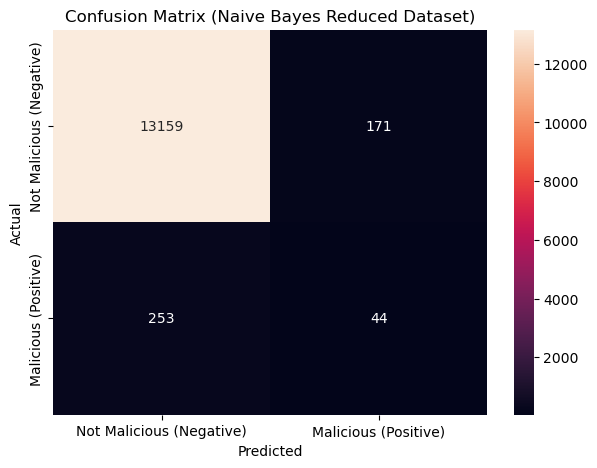

In [103]:
draw_conf_matrix(actual=y_test, predicted=gnb_reduced_predictions, title="Confusion Matrix (Naive Bayes Reduced Dataset)")

In [104]:
print(classification_report(y_true=y_test, y_pred=gnb_reduced_predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     13330
           1       0.20      0.15      0.17       297

    accuracy                           0.97     13627
   macro avg       0.59      0.57      0.58     13627
weighted avg       0.96      0.97      0.97     13627



In [105]:
#Save the optimized model to disk
#gnb_reduced_filename = 'Models/Optimized/gnb_reduced_features_opt.sav'
#pickle.dump(gnb_reduced, open(gnb_reduced_filename, 'wb'))

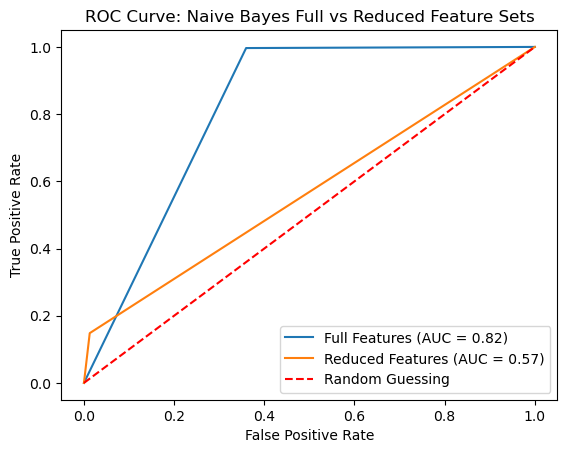

In [106]:
plot_show_auc(gnb_full_predictions, gnb_reduced_predictions, y_test, 'ROC Curve: Naive Bayes Full vs Reduced Feature Sets')

## <font style="color:#008fff;">Evaluation and Tuning: Decision Trees</font>

### Tuning Decision Trees on Reduced Features: 'url_vect', 'is_gov_tld', 'js_obf_len_scaled'

In [86]:
# Grid Search
dc_reduced = DecisionTreeClassifier()

tree_param = {
            'criterion':['gini','entropy'],
            'max_depth':[3,4,5,6,7,8,9,10,15],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [None, 'sqrt']
            }

scorer = make_scorer(roc_auc_score) # Since our AUC score dropped compaed to full feature sets, this is something we want to focus on

grid_search = GridSearchCV(dc_reduced, tree_param, scoring=scorer, cv=3, n_jobs=-1)
grid_search.fit(experiment_X_train.values, y_train.values)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15],
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 2, 4]},
             scoring=make_scorer(roc_auc_score))

In [87]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 4}

In [59]:
# Make a new decision tree based on best parameters
dc_reduced = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    max_features=None,
    min_samples_leaf=4
)
dc_reduced.fit(experiment_X_train.values, y_train.values)
dc_reduced_predictions = dc_reduced.predict(experiment_X_test.values)

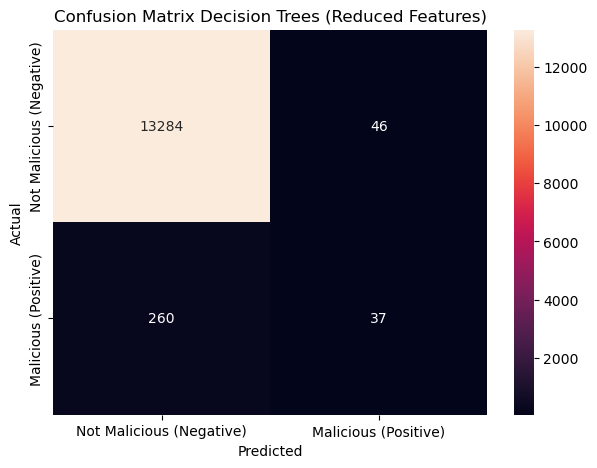

In [60]:
draw_conf_matrix(actual=y_test, predicted=dc_reduced_predictions, title="Confusion Matrix Decision Trees (Reduced Features)")

**Although recall has drastically worsened, we see a slightly better precision. In addition, we hvae a drastically better accuracy:**

In [61]:
print(classification_report(y_true=y_test, y_pred=dc_reduced_predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13330
           1       0.45      0.12      0.19       297

    accuracy                           0.98     13627
   macro avg       0.71      0.56      0.59     13627
weighted avg       0.97      0.98      0.97     13627



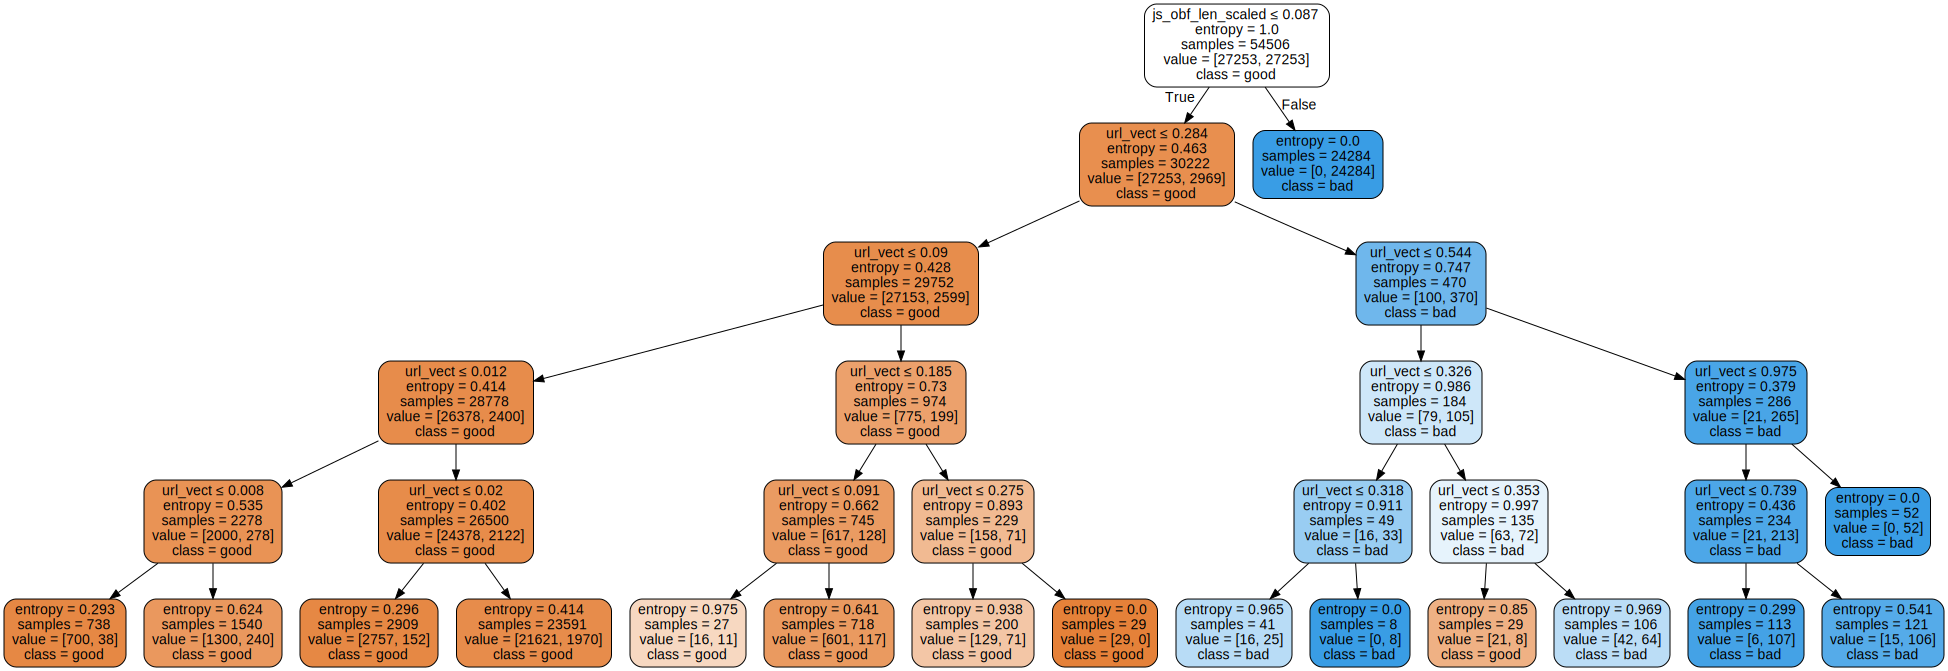

In [64]:
dot_data = sklearn.tree.export_graphviz(dc_reduced, out_file=None, 
                      feature_names=list(experiment_X_train.columns),  
                      class_names=['good', 'bad'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [93]:
#Save the optimized model to disk
#dc_reduced_filename = 'Models/Optimized/dc_reduced_features_opt.sav'
#pickle.dump(dc_reduced, open(dc_reduced_filename, 'wb'))

### Tuning Decision Trees using full features

In [65]:
dc_full = DecisionTreeClassifier()

tree_param = {
            'criterion':['gini','entropy'],
            'max_depth':[3,4,5,6,7,8,9,10,15],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [None, 'sqrt']
            }

grid_search = GridSearchCV(dc_reduced, tree_param, cv=3, n_jobs=-1)
grid_search.fit(X_train.values, y_train.values)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                              min_samples_leaf=4),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15],
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 2, 4]})

In [66]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 1}

In [67]:
dc_full = DecisionTreeClassifier(
    criterion='gini',
    max_depth=6,
    max_features=None,
    min_samples_leaf=1)

dc_full.fit(X_train.values, y_train.values)
dc_full_predictions = dc_full.predict(X_test.values)

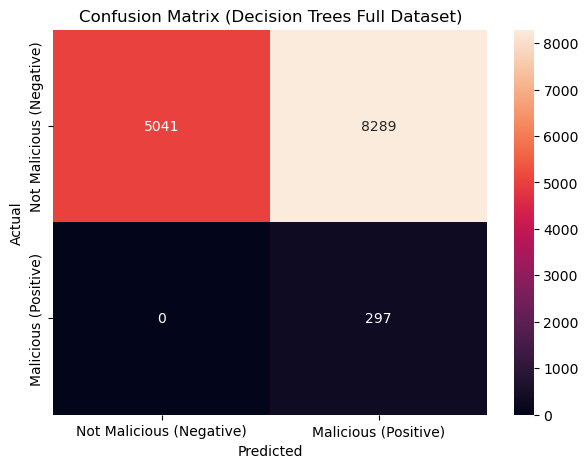

In [68]:
draw_conf_matrix(actual=y_test, predicted=dc_full_predictions, title="Confusion Matrix (Decision Trees Full Dataset)")

In [69]:
print(classification_report(y_true=y_test, y_pred=dc_full_predictions))

              precision    recall  f1-score   support

           0       1.00      0.38      0.55     13330
           1       0.03      1.00      0.07       297

    accuracy                           0.39     13627
   macro avg       0.52      0.69      0.31     13627
weighted avg       0.98      0.39      0.54     13627



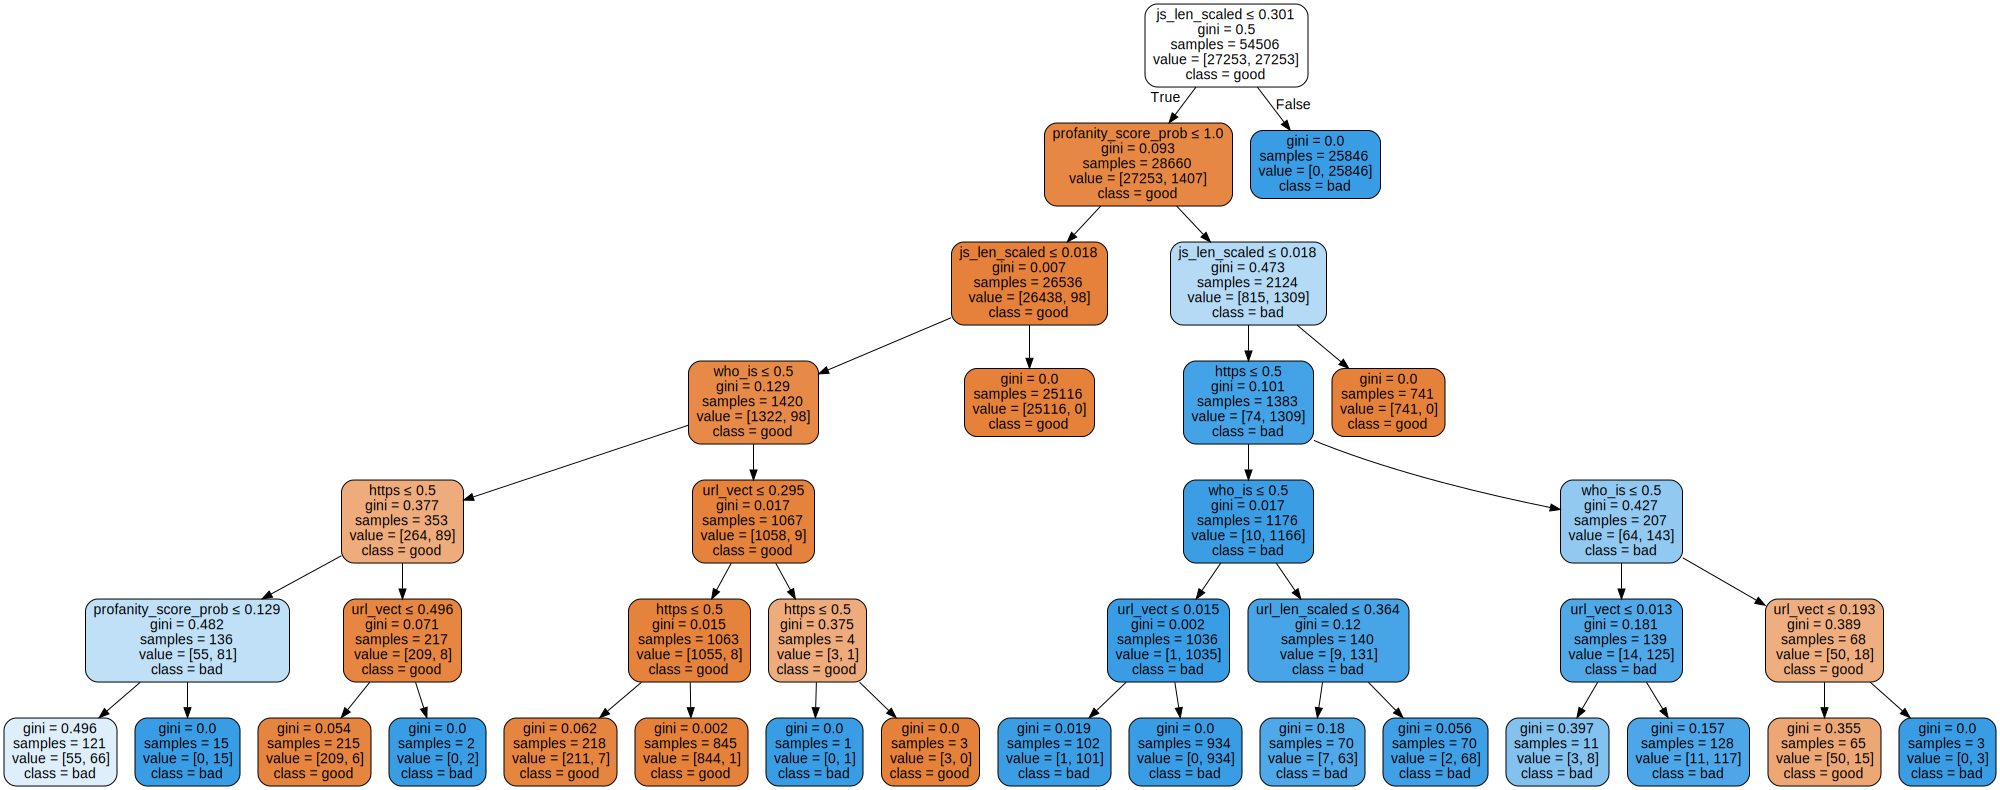

In [70]:
import graphviz

dot_data = sklearn.tree.export_graphviz(dc_full, out_file=None, 
                      feature_names=list(X_train.columns),  
                      class_names=['good', 'bad'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [115]:
#Save the optimized model to disk
# dc_full_filename = 'Models/Optimized/dc_full_features_opt.sav'
# pickle.dump(dc_full, open(dc_full_filename, 'wb'))

### Comparing AUC Curves with Full Features vs Reduced Features (Again, only using 'url_vect', 'is_gov_tld', 'js_obf_len_scaled.'). Notice, however, a worsened AUC with reduced features

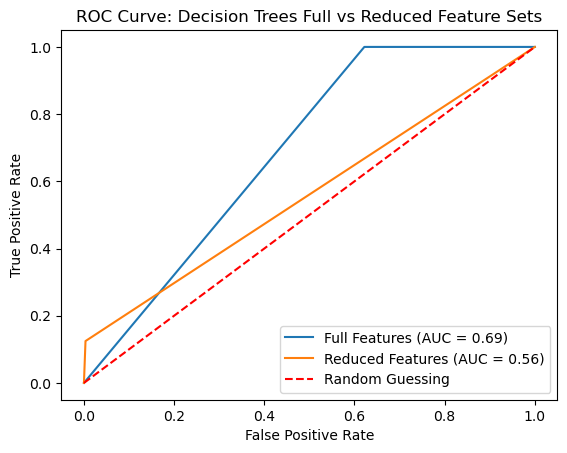

In [71]:
plot_show_auc(dc_full_predictions, dc_reduced_predictions, y_test, 'ROC Curve: Decision Trees Full vs Reduced Feature Sets')

## <font style="color:#008fff;">Evaluation and Tuning: Random Forests</font>

### Tuning Random Forest using Full Features

Grid Video for Random Forest: https://www.youtube.com/watch?v=c4mS7KaOIGY

In [74]:
# Grid Search possible parameters. 

n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)] # Number of trees in random forest
max_features = ['auto', 'sqrt', 'log2'] # Number of features to consider at every split
max_depth = [None,2,4] # Maximum number of levels in tree
min_samples_split = [2, 5] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree

In [75]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [None, 2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [76]:
rfc_full = RandomForestClassifier(random_state=42)
rf_Grid_full = GridSearchCV(estimator = rfc_full, param_grid=param_grid, cv=3, verbose=2, n_jobs = 4)
rf_Grid_full.fit(X_train, y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [None, 2, 4],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             verbose=2)

In [10]:
rf_Grid_full.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 90}

In [17]:
rfc_full = RandomForestClassifier(bootstrap=False, 
                                            max_depth=None, 
                                            max_features='auto', 
                                            min_samples_leaf= 2,
                                            min_samples_split=5,
                                            n_estimators=90
                                           )

rfc_full.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=90)

In [82]:
rfc_full_predictions = rfc_full.predict(X_test.values)

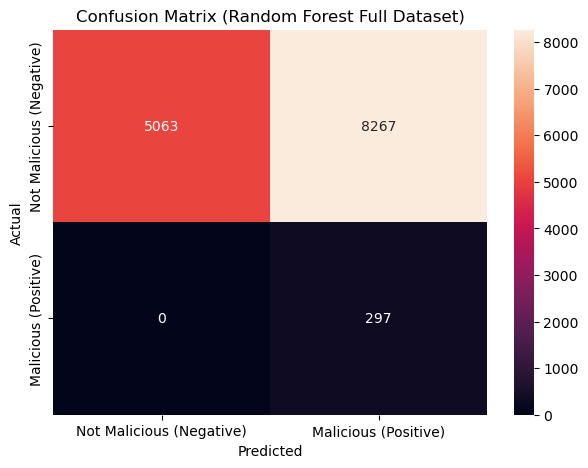

In [83]:
draw_conf_matrix(actual=y_test, predicted=rfc_full_predictions, title="Confusion Matrix (Random Forest Full Dataset)")

In [84]:
print(classification_report(y_true=y_test, y_pred=rfc_full_predictions))

              precision    recall  f1-score   support

           0       1.00      0.38      0.55     13330
           1       0.03      1.00      0.07       297

    accuracy                           0.39     13627
   macro avg       0.52      0.69      0.31     13627
weighted avg       0.98      0.39      0.54     13627



In [116]:
#Save the optimized model to disk
# rfc_full_filename = 'Models/Optimized/rfc_full_features_opt.sav'
# pickle.dump(rfc_full, open(rfc_full_filename, 'wb'))

### Tuning Random forest on reduced features: 'url_vect', 'is_gov_tld', 'js_obf_len_scaled'

In [85]:
chosen_cols = ['url_vect', 'is_gov_tld', 'js_obf_len_scaled']
experiment_X_train = X_train[chosen_cols]
experiment_X_test = X_test[chosen_cols]

In [86]:
rfc_reduced = RandomForestClassifier(random_state=42)
rf_Grid_reduced = GridSearchCV(estimator=rfc_reduced, param_grid=param_grid, cv=3, verbose=2, n_jobs =-1)
rf_Grid_reduced.fit(experiment_X_train, y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [None, 2, 4],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             verbose=2)

In [87]:
rf_Grid_reduced.best_params_

{'bootstrap': True,
 'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [88]:
rfc_reduced = RandomForestClassifier(bootstrap=True,
                                    max_depth=2,
                                    max_features='auto',
                                    min_samples_leaf=1,
                                    min_samples_split=2,
                                    n_estimators=100)
rfc_reduced.fit(experiment_X_train, y_train)

RandomForestClassifier(max_depth=2, max_features='auto')

### Evaluating Random Forest on reduced features

In [89]:
rfc_reduced_predictions = rfc_reduced.predict(experiment_X_test)

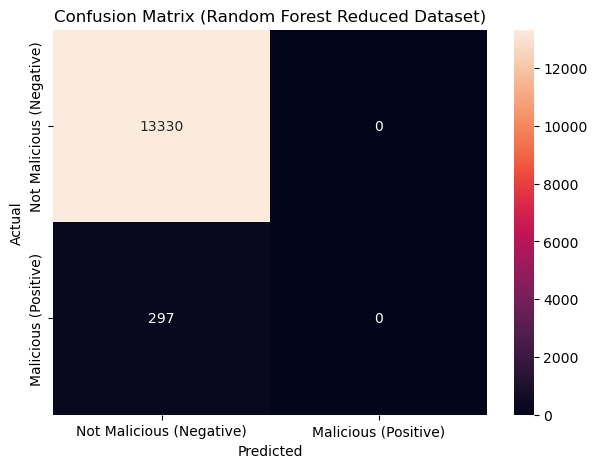

In [90]:
draw_conf_matrix(actual=y_test, predicted=rfc_reduced_predictions, title="Confusion Matrix (Random Forest Reduced Dataset)")

In [91]:
print(classification_report(y_true=y_test, y_pred=rfc_reduced_predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13330
           1       0.00      0.00      0.00       297

    accuracy                           0.98     13627
   macro avg       0.49      0.50      0.49     13627
weighted avg       0.96      0.98      0.97     13627



In [97]:
# Save the optimized model to disk
#rfc_reduced_filename = 'Models/Optimized/rfc_reduced_features_opt.sav'
#pickle.dump(rfc_reduced, open(rfc_reduced_filename, 'wb'))

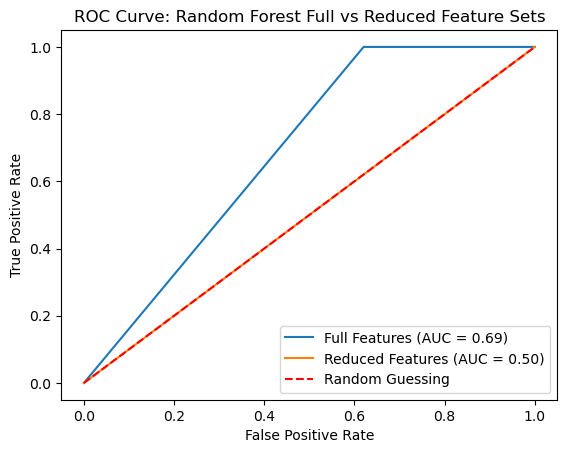

In [92]:
plot_show_auc(rfc_full_predictions, rfc_reduced_predictions, y_test, 'ROC Curve: Random Forest Full vs Reduced Feature Sets')

### NOTE: We wanted to try out larger numbers of estimators during grid search, even to 200 during grid search, but this took way too long (15+ minutes!!!). So for the scope of this project, we only limited our estimators to 10-100 for random forests

## <font style="color:#008fff;">Comparing all ML Models</font>

In [93]:
def draw_bar_graph_metrics(accuracy, precision, recall, f1, title):
    # create a list of model names
    model_names = ['KNN', 'Naive bayes', 'Decision Trees', 'Random Forests']

    # set the width of each bar
    bar_width = 0.2

    # create a figure with a single subplot
    fig, ax = plt.subplots()

    # create a bar graph for the accuracies of each model
    ax.bar(np.arange(len(model_names)), accuracy, width=bar_width, label='Accuracy', color='blue')
    ax.bar(np.arange(len(model_names))+bar_width, precision, width=bar_width, label='Precision', color='red')
    ax.bar(np.arange(len(model_names))+2*bar_width, recall, width=bar_width, label='Recall', color='green')
    ax.bar(np.arange(len(model_names))+3*bar_width, f1, width=bar_width, label='F1', color='orange')

    # add x-axis tick labels and legend
    ax.set_xticks(np.arange(len(model_names))+bar_width)
    ax.set_xticklabels(model_names)
    ax.legend()

    # add axis labels and title
    ax.set_xlabel('Model')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    
    # Set y-axis and ticks
    ax.set_ylim([0, 1])
    ax.set_yticks(np.arange(0.0, 1.0, 0.1))

    # add a dashed background to the y-axis
    ax.yaxis.grid(color='gray', linestyle='--')

    # adjust the plot layout
    fig.tight_layout()
    plt.show()

### Reading in our finalized ML Models After Tuning Parameters (/Optimized directory)

In [94]:
# ---------------------- KNN ----------------------
knn_full_filename = 'Models/Optimized/knn_full_features_opt.sav' # Full feature set
knn_full = pickle.load(open(knn_full_filename, 'rb'))

# ---------------------- Naive Bayes ----------------------
gnb_full_filename = 'Models/gnb_full_features.sav' # (STill need to optimized Naive Bayes)
gnb_full = pickle.load(open(gnb_full_filename, 'rb'))

# ---------------------- Decision Trees ----------------------
dc_full_filename = 'Models/Optimized/dc_full_features_opt.sav'
dc_full = pickle.load(open(dc_full_filename, 'rb'))

# ---------------------- Random Forest ----------------------
rfc_full_filename = 'Models/Optimized/rfc_full_features_opt.sav'
rfc_full = pickle.load(open(rfc_full_filename, 'rb'))

### Plotting a bar graph to compare accuracy, precision, recall, and f1 scores side by side for models trained on full feature sets. 

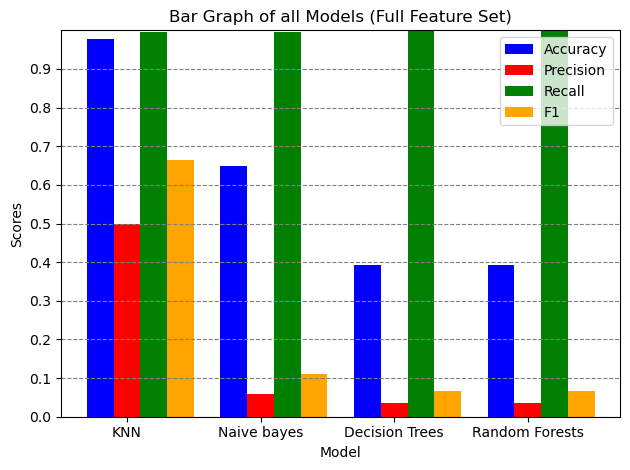

In [95]:
# Getting back their predictions
knn_full_predictions = knn_full.predict(X_test.values)
gnb_full_predictions = gnb_full.predict(X_test.values)
dc_full_predictions = dc_full.predict(X_test.values)
rfc_full_predictions = rfc_full.predict(X_test.values)

# create a list of accuracy, precision, and recall values for each model
accuracy_f = [
    accuracy_score(y_test, knn_full_predictions), 
    accuracy_score(y_test, gnb_full_predictions),
    accuracy_score(y_test, dc_full_predictions),
    accuracy_score(y_test, rfc_full_predictions)
]

precision_f = [
    precision_score(y_test, knn_full_predictions), 
    precision_score(y_test, gnb_full_predictions),
    precision_score(y_test, dc_full_predictions),
    precision_score(y_test, rfc_full_predictions)
]

recall_f = [
    recall_score(y_test, knn_full_predictions), 
    recall_score(y_test, gnb_full_predictions),
    recall_score(y_test, dc_full_predictions),
    recall_score(y_test, rfc_full_predictions)
]

f1_f = [
    f1_score(y_test, knn_full_predictions), 
    f1_score(y_test, gnb_full_predictions),
    f1_score(y_test, dc_full_predictions),
    f1_score(y_test, rfc_full_predictions)
]

draw_bar_graph_metrics(accuracy_f, precision_f, recall_f, f1_f, 'Bar Graph of all Models (Full Feature Set)')

### Plotting a bar graph to compare accuracy, precision, recall, and f1 scores side by side for models trained on reduced feature sets. 

In [111]:
knn_reduced_filename = 'Models/Optimized/knn_reduced_features_opt.sav' # Reduced feature set
knn_reduced = pickle.load(open(knn_reduced_filename, 'rb'))

gnb_reduced_filename = 'Models/Optimized/gnb_reduced_features_opt.sav'
gnb_reduced = pickle.load(open(gnb_reduced_filename, 'rb'))

dc_reduced_filename = 'Models/Optimized/dc_reduced_features_opt.sav'
dc_reduced = pickle.load(open(dc_reduced_filename, 'rb'))

rfc_reduced_filename = 'Models/Optimized/rfc_reduced_features_opt.sav'
rfc_reduced = pickle.load(open(rfc_reduced_filename, 'rb'))

In [112]:
X_test_reduced_5 = X_test[['who_is', 'https', 'profanity_score_prob', 'js_len_scaled', 'js_obf_len_scaled']]
X_test_reduced_3 = X_test[['url_vect', 'is_gov_tld', 'js_obf_len_scaled']]

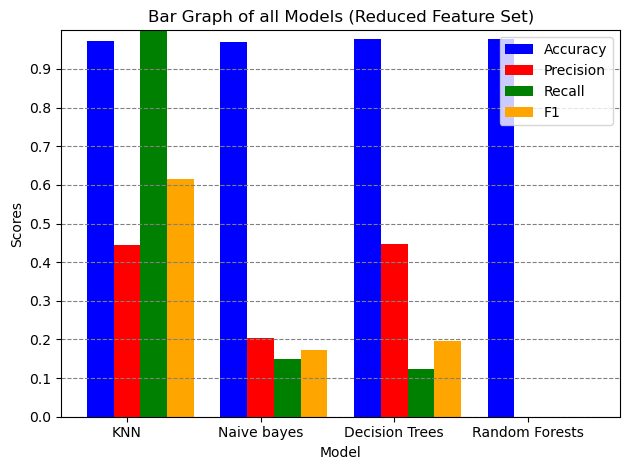

In [113]:
knn_reduced_predictions = knn_reduced.predict(X_test_reduced_5.values)
gnb_reduced_predictions = gnb_reduced.predict(X_test_reduced_3.values)
dc_reduced_predictions = dc_reduced.predict(X_test_reduced_3.values)
rfc_reduced_predictions = rfc_reduced.predict(X_test_reduced_3.values)

# create a list of accuracy, precision, and recall values for each model
accuracy_r = [
    accuracy_score(y_test, knn_reduced_predictions), 
    accuracy_score(y_test, gnb_reduced_predictions),
    accuracy_score(y_test, dc_reduced_predictions),
    accuracy_score(y_test, rfc_reduced_predictions)
]

precision_r = [
    precision_score(y_test, knn_reduced_predictions),             
    precision_score(y_test, gnb_reduced_predictions),
    precision_score(y_test, dc_reduced_predictions),
    precision_score(y_test, rfc_reduced_predictions)
]

recall_r = [
    recall_score(y_test, knn_reduced_predictions),         
    recall_score(y_test, gnb_reduced_predictions),
    recall_score(y_test, dc_reduced_predictions),
    recall_score(y_test, rfc_reduced_predictions)
]

f1_r = [
    f1_score(y_test, knn_reduced_predictions), 
    f1_score(y_test, gnb_reduced_predictions),
    f1_score(y_test, dc_reduced_predictions),
    f1_score(y_test, rfc_reduced_predictions)
]

draw_bar_graph_metrics(accuracy_r, precision_r, recall_r, f1_r, 'Bar Graph of all Models (Reduced Feature Set)')

### Observations to be made:
 - Our models seemed to hvae an extremely high recall (Percentage of actual malicious URL's that were correctly classified) for both full and reduced feature sets.
 - However, for both full and reduced feature sets, our models seem to have a low precision (Which is no surprise as precision and recall do have a tradeoff)
 - For the full feature sets, KNN seemed to have the highest accuracy
 - For reduced feature sets, Naive Nbayes seemed to have the highest accuracy

### Comparing AUC Scores of all ML models split by both full feature and reduced feature sets

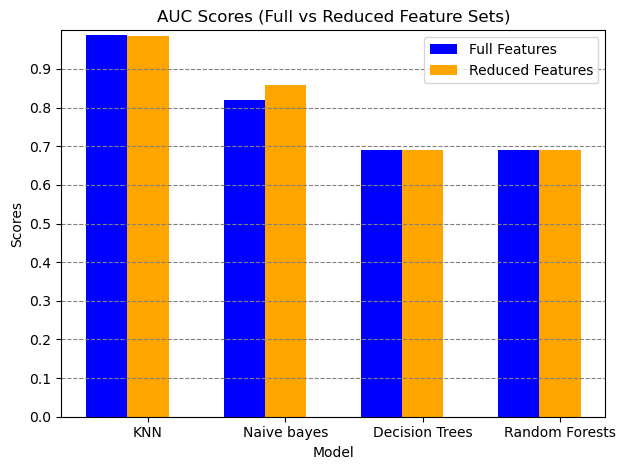

In [98]:
auc_f = [
    roc_auc_score(y_test, knn_full_predictions),
    roc_auc_score(y_test, gnb_full_predictions),
    roc_auc_score(y_test, dc_full_predictions),
    roc_auc_score(y_test, rfc_full_predictions)
]

auc_r = [
    roc_auc_score(y_test, knn_reduced_predictions),
    roc_auc_score(y_test, gnb_reduced_predictions),
    roc_auc_score(y_test, dc_reduced_predictions),
    roc_auc_score(y_test, rfc_reduced_predictions)
]

model_names = ['KNN', 'Naive bayes', 'Decision Trees', 'Random Forests']
bar_width = 0.3
fig, ax = plt.subplots()

# create a bar graph for the accuracies of each model
ax.bar(np.arange(len(model_names)), auc_f, width=bar_width, label='Full Features', color='blue')
ax.bar(np.arange(len(model_names))+bar_width, auc_r, width=bar_width, label='Reduced Features', color='orange')

# add x-axis tick labels and legend
ax.set_xticks(np.arange(len(model_names))+bar_width)
ax.set_xticklabels(model_names)
ax.legend()

# add axis labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('AUC Scores (Full vs Reduced Feature Sets)')

# Set y-axis and ticks
ax.set_ylim([0, 1])
ax.set_yticks(np.arange(0.0, 1.0, 0.1))

# add a dashed background to the y-axis
ax.yaxis.grid(color='gray', linestyle='--')

# adjust the plot layout
fig.tight_layout()
plt.show()

 - AUC scores were surprisingly higher than expected (High 0.6's and above)